In [ ]:
%tensorflow_version 1.x

import string
import glob

from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.models import load_model

import numpy as np
from numpy import array
from keras.preprocessing import image
from time import time
from datetime import datetime
from keras.applications.inception_v3 import preprocess_input
!pip install tqdm
from tqdm import tqdm
import pickle
from pickle import dump, load
import os
from keras import Input, layers
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.merge import add
from keras.optimizers import Adam, RMSprop
from keras import optimizers
from keras.callbacks import History, Callback
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as k
from keras.preprocessing import sequence
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline



In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title Preparing Text Data from here
####Step 3 That is Preparing Text Data

def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:100])


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:

def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


Before cleaning there are capital letter, single letters

In [ ]:
#print(list(descriptions.keys())[:5])
print(descriptions['1001773457_577c3a7d70'])

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


In [ ]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

After cleaning, single letters are removed and all are in lower case

In [ ]:
print(descriptions['1001773457_577c3a7d70'])

['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other']


In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]   #separates image_id and jpg
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr_8k.trainImages.txt' #this contains image id 
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
#@title Preparing Photo Data from here
# Below path contains all the images
images = '/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
len(img)

8094

### ***train*** is list of image id : like ['1001773457_577c3a7d70' , '1001773457_577c3a7d71' ...] len(train) = 6000






*** *italicized text*img*** is a list of path of all images : like  ['/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/1001773457_577c3a7d70.jpg' , ..] len(img) = 8092

train_images is a list of image id with extension : like ['1001773457_577c3a7d70.jpg' , ...], len(train_images) = 6000 

In [ ]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
#----this is different than train, train contains only image_id whereas train_images contains image_id with extension like "12345.jpg"
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names           
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i)# Add it to the list of train images
print("training images= ",len(train_img))

training images=  6000


train_img contains path of only training images

In [ ]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images
print("testing images= ",len(test_img))

testing images=  1000


test_img contains path of only test images len(test_img) = 1000

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [ ]:
# Load the inception v3 model , import - from tensorflow import keras ,from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


96116736/96112376 [==============================] - 2s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3, import - from keras.models import Model
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
#import - np, numpy.array, from keras.preprocessing import image,from keras.applications.inception_v3 import preprocess_input

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
#import - from datetime import datetime,from time import time
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once (takes approx 45 min)


# start = time()
# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)


In [ ]:
# Save the bottleneck test features to disk, import pickle

# with open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)


In [ ]:
# Call the funtion to encode all the test images - Execute this only once


# start = time()
# encoding_test = {}
# for img in tqdm(test_img):
#     encoding_test[img[len(images):]] = encode(img)
# print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck test features to disk


# with open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/testing/vocab.pkl', 'wb') as f:
#         pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/My Drive/Colab Notebooks/testing/ixtoword.pkl', 'wb') as f:
#         pickle.dump(ixtoword, f, pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/My Drive/Colab Notebooks/testing/wordtoix.pkl', 'wb') as f:
#         pickle.dump(wordtoix, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
# Load Glove vectors, import os
glove_dir = '/content/drive/My Drive/Colab Notebooks/glovedir'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
start = time()
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.0027129650115966797


In [ ]:
embedding_matrix.shape

(1652, 200)

In [ ]:
#from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
#                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
#from keras.layers.merge import add

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Traning Phase 

In [ ]:
epochs = 30
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
#from keras.callbacks import History, Callback

history = History()

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
# from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[tensorboard_callback] )
    # model.save('/content/drive/My Drive/Colab Notebooks/model_weights/model_' + str(i) + '.h5')


Epoch 1/1
   5/2000 [..............................] - ETA: 19:38 - loss: 6.9765

/tensorflow-1.15.2/python3.6/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.138170). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


2000/2000 [==============================] - 123s 62ms/step - loss: 4.1311
Epoch 1/1
2000/2000 [==============================] - 121s 61ms/step - loss: 3.4220
Epoch 1/1
2000/2000 [==============================] - 121s 61ms/step - loss: 3.1987
Epoch 1/1
2000/2000 [==============================] - 122s 61ms/step - loss: 3.0644
Epoch 1/1
2000/2000 [==============================] - 119s 60ms/step - loss: 2.9685
Epoch 1/1
2000/2000 [==============================] - 120s 60ms/step - loss: 2.8967
Epoch 1/1
2000/2000 [==============================] - 120s 60ms/step - loss: 2.8409
Epoch 1/1
2000/2000 [==============================] - 119s 59ms/step - loss: 2.7929
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.7495
Epoch 1/1
2000/2000 [==============================] - 119s 59ms/step - loss: 2.7178
Epoch 1/1
2000/2000 [==============================] - 117s 59ms/step - loss: 2.6864
Epoch 1/1
2000/2000 [==============================] - 120s 60ms/step - los

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/model_weights/model_epoch30.h5')

In [ ]:
#import keras as k

k.set_value(model.optimizer.lr,0.0001)
epochs = 100
number_pics_per_bath = 12
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    print(i)
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=2,callbacks=[tensorboard_callback])
    #model.save('./model_weights/model_' + str(i) + '.h5')

0
Epoch 1/1
 - 37s - loss: 2.4753
1
Epoch 1/1
 - 38s - loss: 2.4168
2
Epoch 1/1
 - 37s - loss: 2.3927
3
Epoch 1/1
 - 37s - loss: 2.3776
4
Epoch 1/1
 - 37s - loss: 2.3692
5
Epoch 1/1
 - 38s - loss: 2.3628
6
Epoch 1/1
 - 37s - loss: 2.3529
7
Epoch 1/1
 - 38s - loss: 2.3465
8
Epoch 1/1
 - 38s - loss: 2.3388
9
Epoch 1/1
 - 38s - loss: 2.3342
10
Epoch 1/1
 - 37s - loss: 2.3269
11
Epoch 1/1
 - 38s - loss: 2.3217
12
Epoch 1/1
 - 37s - loss: 2.3197
13
Epoch 1/1
 - 37s - loss: 2.3152
14
Epoch 1/1
 - 38s - loss: 2.3108
15
Epoch 1/1
 - 38s - loss: 2.3080
16
Epoch 1/1
 - 37s - loss: 2.3050
17
Epoch 1/1
 - 37s - loss: 2.2977
18
Epoch 1/1
 - 37s - loss: 2.2988
19
Epoch 1/1
 - 37s - loss: 2.2953
20
Epoch 1/1
 - 37s - loss: 2.2904
21
Epoch 1/1
 - 38s - loss: 2.2863
22
Epoch 1/1
 - 38s - loss: 2.2870
23
Epoch 1/1
 - 38s - loss: 2.2829
24
Epoch 1/1
 - 37s - loss: 2.2790
25
Epoch 1/1
 - 37s - loss: 2.2778
26
Epoch 1/1
 - 37s - loss: 2.2724
27
Epoch 1/1
 - 37s - loss: 2.2716
28
Epoch 1/1
 - 38s - loss: 2.

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/model_weights/caption_model.h5')

In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/model_weights/caption_model.h5')

# Testing 

In [ ]:
images = '/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/'

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def beam_search_predictions(photo, index = 3):
    start = [wordtoix['startseq']]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            #e = encoding_test[photo[len(images):]]
            preds = model.predict([photo, np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def print_predicitions_above_threshold(list1):
    threshold=0.8 
    x = np.array(list1) 
    print(np.unique(x)) 

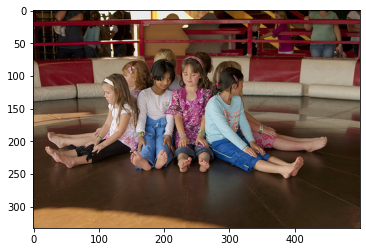

2445283938_ff477c7952
['two girls are sitting on bench'
 'two girls are sitting on the floor outside store'
 'two young girls are sitting on wooden bench']

Final Cumulative BLEU score: 0.6635900288406558





/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


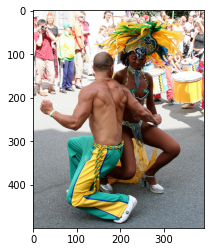

311146855_0b65fdb169
['girl in pink bikini is standing in front of crowd of people'
 'two girls in skimpy outfits are standing in front of large pool'
 'two girls in skimpy outfits walk down the street']

Final Cumulative BLEU score: 0.5885309152563716





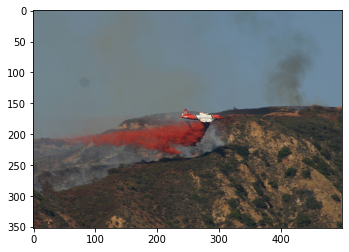

3692593096_fbaea67476
['man is standing in front of mountain'
 'man is standing on top of mountain'
 'man is standing on top of mountain overlooking the mountains']

Final Cumulative BLEU score: 0.7333535354048399





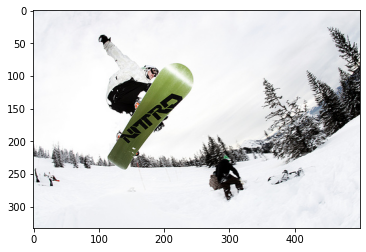

3108732084_565b423162
['man in red jacket is snowboarding down hill'
 'person in pink coat is snowboarding down hill'
 'person in red jacket is snowboarding down slope'
 'person on snowboard in the air above snow']

Final Cumulative BLEU score: 0.5821132974768377





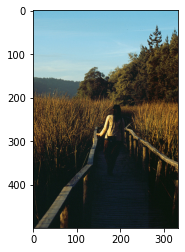

473220329_819a913bbb
['little girl in pink shirt and jeans walks down gravel path'
 'little girl stands on the shore of lake'
 'two girls are walking along river']

Final Cumulative BLEU score: 0.6510310627537994





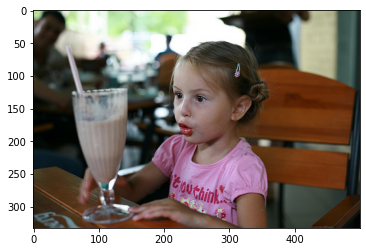

3741462565_cc35966b7a
['little girl in pink shirt is blowing huge bubble'
 'little girl is eating piece of']

Final Cumulative BLEU score: 0.5283950660753977





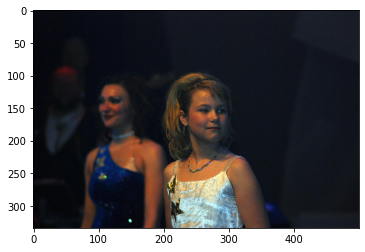

2396691909_6b8c2f7c44
['woman in black and white tank top is standing in front of group of people'
 'woman in black and white tank top is standing in front of the beach'
 'woman in black and white tank top is standing next to another girl in red dress'
 'woman in black dances with her hair']

Final Cumulative BLEU score: 0.47738541653588173





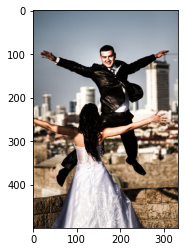

3424424006_98f9d1921c
['two young men are playing with ball'
 'young girl in pink dress is standing on balance beam while another girl watches'
 'young girl wearing pink flip flops plays with white guitar']

Final Cumulative BLEU score: 0.6016764460110355





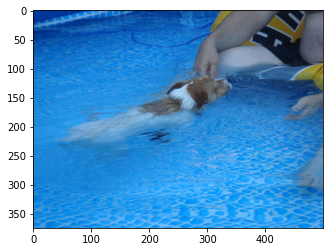

2677656448_6b7e7702af
['little girl in pink bathing suit feeding her younger girl'
 'two boys are playing in the water with ball'
 'two boys in swimming trunks are playing in the water'
 'two children are playing in the water']

Final Cumulative BLEU score: 0.5796723808811846





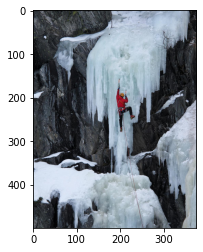

3429956016_3c7e3096c2
['man in red jacket climbs rock wall'
 'man is standing on snowy hill with his arms outstretched'
 'two people climbing snowy hill' 'two people stand on snowy hill']

Final Cumulative BLEU score: 0.587801268860945





In [ ]:
list2=[41,424,922, 337, 161, 248,104, 96, 844,351,304,689,179,898]

for k in range(19,30):
  z=k
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048)) 
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  des=os.path.splitext(pic)[0]
  #print (z)
  print(des)
  #print(descriptions[des])
  predictions=[]
  start=time()
  predictions.append(beam_search_predictions(image,index=1))
  predictions.append(beam_search_predictions(image,index=2))
  predictions.append(beam_search_predictions(image,index=3))
  predictions.append(beam_search_predictions(image,index=4))
  print_predicitions_above_threshold(predictions)
  #print(time()-start)


    #calculation of BLEU scores
  candidate=[]
  reference=[]
  score=0

  for i in range(4):
    candidate.append(predictions[i])

  for i in range(5):
    reference.append(descriptions[des][i].split())

  for i in range(4):
    temp=sentence_bleu(reference,candidate[i].split(),smoothing_function=SmoothingFunction().method0)
    score+=temp
  #print('Sentence '+str(i+1)+ ' score: '+str(temp))
  print('\nFinal Cumulative BLEU score: '+ str(score/4)+'\n\n\n')


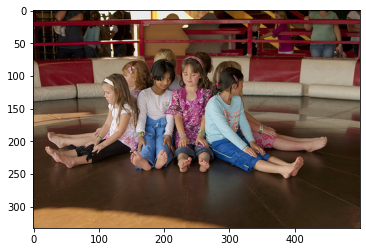

Greedy: two girls are sitting in row of glass


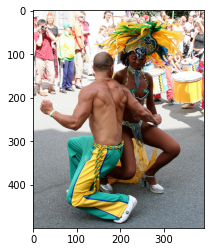

Greedy: man in red shirt is holding flag rope


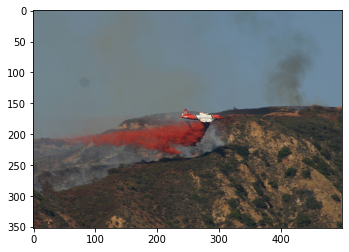

Greedy: man in red shirt is standing on top of mountain


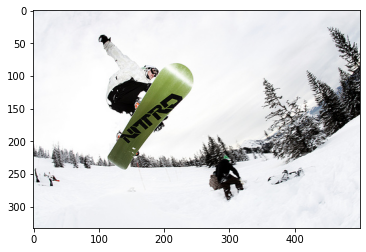

Greedy: snowboarder is jumping over snow covered hill


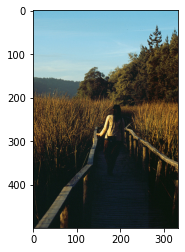

Greedy: man in red shirt and jeans is standing on the edge of cliff overlooking the river


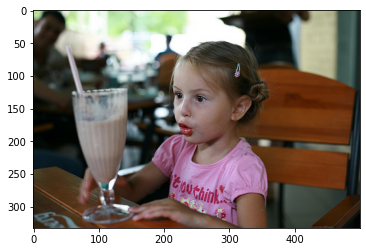

Greedy: two young boys are playing with each other on the grass


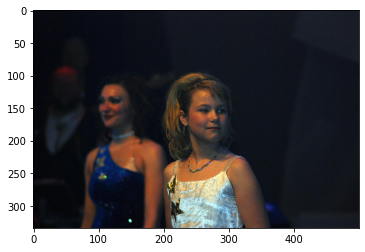

Greedy: woman in black dress is holding up peace sign


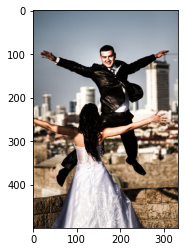

Greedy: two children are playing in the sand


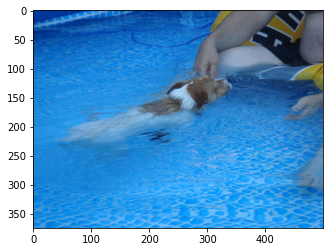

Greedy: two children are playing in the water


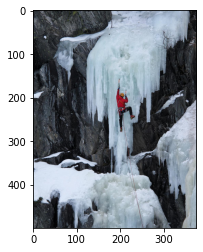

Greedy: man is standing on top of rock with his arms outstretched


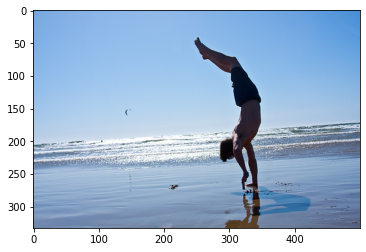

Greedy: man in red shorts and black shorts is jumping over mound of sand


In [ ]:
# # import matplotlib.pyplot as plt
# # import matplotlib
# # %matplotlib inline

# for z in range(19,30):
#   pic = list(encoding_test.keys())[z]
#   image = encoding_test[pic].reshape((1,2048))
#   x=plt.imread(images+pic)
#   plt.imshow(x)
#   plt.show()
#   print("Greedy:",greedySearch(image))